# 03. 데이터 전처리 및 Feature Engineering

**목표**: 모델링을 위한 데이터 준비 및 파생 변수 생성

## 📋 작업 계획

1. 데이터 병합 (KOBIS + Naver)
2. Feature Engineering
   - 장르 인코딩
   - Ticket Power 계산
   - 검색 트렌드 파생 변수
   - 시간 기반 변수
3. 데이터 정제
   - 결측치 처리
   - 이상치 처리
   - 스케일링
4. Train/Val/Test 분할

## 1. 라이브러리 및 데이터 로드

In [22]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 루트 경로 추가
sys.path.append('..')

from utils.data_collection import load_data, save_data
from utils.preprocessing import (
    create_feature_dataset,
    extract_search_features,
    calculate_ticket_power,
    encode_genres,
    extract_time_features,
    handle_missing_values,
    remove_outliers,
    scale_features
)

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [23]:
# 데이터 로드
boxoffice_df = load_data('data/raw/kobis_boxoffice.csv')
movie_details_df = load_data('data/raw/kobis_movie_details.csv')
search_trends_df = load_data('data/raw/naver_search_trends.csv')

print("데이터 로드 완료!")

데이터 로드 완료!


## 2. 데이터 병합 및 기본 Feature 생성

In [24]:
# 영화별 최종 관객수 계산
final_audience = boxoffice_df.groupby('movieNm').agg({
    'audiAcc': 'max',
    'openDt': 'first',
    'movieCd': 'first'
}).reset_index()

print(f"고유 영화 수: {len(final_audience)}")
final_audience.head()

고유 영화 수: 1252


,movieNm,audiAcc,openDt,movieCd
0,#살아있다,1903703,2020-06-24,20193069
1,#아이엠히어,14393,2021-01-14,20197277
2,007 노 타임 투 다이,1222296,2021-09-29,20191061
3,100% 울프: 푸들이 될 순 없어,14153,2020-12-24,20202128
4,1917,860622,2020-02-19,20192399


In [25]:
# 영화 상세 정보 병합
df = pd.merge(
    final_audience,
    movie_details_df,
    on=['movieCd', 'movieNm'],
    how='left',
    suffixes=('', '_detail')
)

# openDt 중복 컬럼 처리
if 'openDt_detail' in df.columns:
    df['openDt'] = df['openDt'].fillna(df['openDt_detail'])
    df = df.drop('openDt_detail', axis=1)

print(f"병합 후 데이터 크기: {df.shape}")
df.head()

병합 후 데이터 크기: (1252, 13)


,movieNm,audiAcc,openDt,movieCd,movieNmEn,prdtYear,typeNm,nations,genres,directors,actors,watchGradeNm,distributors
0,#살아있다,1903703,2020-06-24,20193069,#ALIVE,2019.0,장편,한국,드라마,조일형,"유아인,박신혜,전배수,김학선,김현우",15세이상관람가,롯데컬처웍스(주)롯데엔터테인먼트
1,#아이엠히어,14393,2021-01-14,20197277,#iamhere,2019.0,장편,프랑스,"멜로/로맨스,코미디",에릭 라티고,"알랭 샤바,배두나,이명자,선종남,김자금",12세이상관람가,(주)넥스트엔터테인먼트월드(NEW)
2,007 노 타임 투 다이,1222296,2021-09-29,20191061,007 No Time To Die,2021.0,장편,미국,액션,캐리 후쿠나가,"다니엘 크레이그,라미 말렉,라샤냐 린치,레아 세이두,벤 위쇼",12세이상관람가,유니버설픽쳐스인터내셔널 코리아(유)
3,100% 울프: 푸들이 될 순 없어,14153,2020-12-24,20202128,100% Wolf,2020.0,장편,호주,애니메이션,알렉스 스타더만,NaN,전체관람가,(주)팝엔터테인먼트
4,1917,860622,2020-02-19,20192399,1917,2019.0,장편,미국,"드라마,전쟁",샘 멘데스,"조지 맥케이,딘-찰스 채프먼,콜린 퍼스,베네딕트 컴버배치,마크 스트롱",15세이상관람가,(주)스마일이엔티


## 3. Feature Engineering

### 3.1 검색 트렌드 파생 변수

In [26]:
# 검색 트렌드 특성 추출
search_features = extract_search_features(search_trends_df, df)

print("검색 트렌드 Feature:")
print(search_features.columns.tolist())
search_features.head()

검색 트렌드 Feature:
['movieNm', 'search_4w_before', 'search_2w_before', 'search_1w_before', 'search_opening', 'search_1w_after', 'max_search', 'avg_search', 'search_volatility', 'search_growth_rate']


,movieNm,search_4w_before,search_2w_before,search_1w_before,search_opening,search_1w_after,max_search,avg_search,search_volatility,search_growth_rate
0,#살아있다,20.9,41.4,55.8,66.3,49.9,66.3,43.050000,17.923699,1.669856
1,#아이엠히어,7.1,13.9,20.8,25.9,16.0,25.9,15.166667,7.432272,1.929577
2,007 노 타임 투 다이,17.5,35.6,60.3,73.0,38.9,73.0,41.266667,21.594320,2.445714
3,100% 울프: 푸들이 될 순 없어,5.0,5.9,9.6,10.9,7.1,10.9,7.250000,2.482539,0.920000
4,1917,10.6,23.8,39.7,39.4,23.6,39.7,26.500000,11.227823,2.745283


In [27]:
# 검색 트렌드 병합
df = pd.merge(df, search_features, on='movieNm', how='left')
print(f"병합 후 컬럼 수: {len(df.columns)}")

병합 후 컬럼 수: 22


### 3.2 Ticket Power 계산

In [28]:
# 감독 Ticket Power
director_power = calculate_ticket_power(df, 'director')
df['director_power'] = df.index.map(director_power)

# 배우 Ticket Power
actor_power = calculate_ticket_power(df, 'actor')
df['actor_power'] = df.index.map(actor_power)

# 종합 Ticket Power (가중 평균)
df['ticket_power'] = 0.4 * df['director_power'] + 0.6 * df['actor_power']

print("Ticket Power 계산 완료!")
df[['movieNm', 'director_power', 'actor_power', 'ticket_power']].head(10)

Ticket Power 계산 완료!


,movieNm,director_power,actor_power,ticket_power
0,#살아있다,28339.5,28339.50,28339.50
1,#아이엠히어,28339.5,28339.50,28339.50
2,007 노 타임 투 다이,28339.5,798920.00,490687.80
3,100% 울프: 푸들이 될 순 없어,28339.5,28339.50,28339.50
4,1917,28339.5,28339.50,28339.50
5,1942: 언노운 배틀,28339.5,28339.50,28339.50
6,1947 보스톤,2546967.0,2647834.75,2607487.65
7,1980,28339.5,58650.00,46525.80
8,1984 최동원,28339.5,28339.50,28339.50
9,"1초 앞, 1초 뒤",28339.5,55107.00,44400.00


### 3.3 장르 인코딩

In [29]:
# 장르 One-Hot Encoding
df = encode_genres(df, genre_column='genres')

# 생성된 장르 컬럼 확인
genre_cols = [col for col in df.columns if col.startswith('genre_')]
print(f"장르 컬럼 수: {len(genre_cols)}")
print(f"장르 목록: {genre_cols}")

장르 컬럼 수: 22
장르 목록: ['genre_애니메이션', 'genre_어드벤처', 'genre_사극', 'genre_SF', 'genre_멜로/로맨스', 'genre_다큐멘터리', 'genre_뮤지컬', 'genre_판타지', 'genre_공연', 'genre_전쟁', 'genre_공포(호러)', 'genre_서부극(웨스턴)', 'genre_드라마', 'genre_액션', 'genre_범죄', 'genre_기타', 'genre_스릴러', 'genre_성인물(에로)', 'genre_코미디', 'genre_미스터리', 'genre_가족', 'genre_Unknown']


### 3.4 시간 기반 변수

In [30]:
# 개봉일 기반 변수 추출
df = extract_time_features(df, date_column='openDt')

# 생성된 시간 관련 컬럼 확인
time_cols = ['release_month', 'release_quarter', 'release_year', 
             'release_dayofweek', 'is_weekend', 'season']
season_cols = [col for col in df.columns if col.startswith('season_')]

print("시간 기반 Feature 생성 완료!")
print(f"시즌 컬럼: {season_cols}")
df[['movieNm', 'openDt'] + time_cols].head()

시간 기반 Feature 생성 완료!
시즌 컬럼: ['season_fall', 'season_spring', 'season_summer_peak', 'season_winter_peak']


,movieNm,openDt,release_month,release_quarter,release_year,release_dayofweek,is_weekend,season
0,#살아있다,2020-06-24,6.0,2.0,2020.0,2.0,0,spring
1,#아이엠히어,2021-01-14,1.0,1.0,2021.0,3.0,0,winter_peak
2,007 노 타임 투 다이,2021-09-29,9.0,3.0,2021.0,2.0,0,fall
3,100% 울프: 푸들이 될 순 없어,2020-12-24,12.0,4.0,2020.0,3.0,0,winter_peak
4,1917,2020-02-19,2.0,1.0,2020.0,2.0,0,winter_peak


### 3.5 배급사 인코딩

In [31]:
# 배급사 Frequency Encoding
if 'distributors' in df.columns:
    distributor_counts = df['distributors'].value_counts()
    df['distributor_freq'] = df['distributors'].map(distributor_counts)
    
    # Target Encoding
    distributor_means = df.groupby('distributors')['audiAcc'].mean()
    df['distributor_target'] = df['distributors'].map(distributor_means)
    
    print("배급사 인코딩 완료!")
    df[['distributors', 'distributor_freq', 'distributor_target']].head()

배급사 인코딩 완료!


### 3.6 관람등급 인코딩

In [32]:
# 관람등급 Label Encoding
if 'watchGradeNm' in df.columns:
    from sklearn.preprocessing import LabelEncoder
    
    le = LabelEncoder()
    df['watchGrade_encoded'] = le.fit_transform(df['watchGradeNm'].fillna('Unknown'))
    
    print("관람등급 인코딩 완료!")
    print(f"등급 종류: {df['watchGradeNm'].unique()}")

관람등급 인코딩 완료!
등급 종류: ['15세이상관람가' '12세이상관람가' '전체관람가' nan '청소년관람불가' '12세관람가' '15세관람가' '중학생이상관람가'
 '고등학생이상관람가' '18세관람가' '연소자관람불가' '연소자관람가' '15세 미만인 자는 관람할 수 없는 등급 '
 '18세 미만인 자는 관람할 수 없는 등급']


## 4. 데이터 정제

### 4.1 결측치 확인 및 처리

=== 결측치 현황 ===
actors                174
directors             154
movieNmEn              59
watchGradeNm           37
distributors           35
distributor_freq       35
distributor_target     35
prdtYear               24
genres                 24
typeNm                 23
nations                23
openDt                 18
release_month          18
release_quarter        18
release_year           18
release_dayofweek      18
dtype: int64


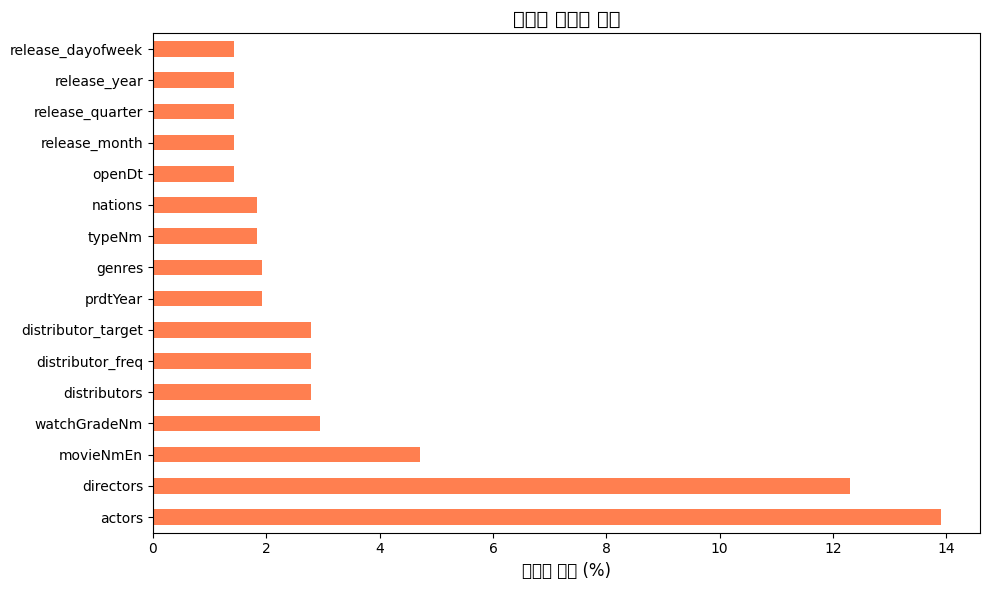

In [33]:
# 결측치 확인
missing = df.isnull().sum()
missing_cols = missing[missing > 0].sort_values(ascending=False)

print("=== 결측치 현황 ===")
if len(missing_cols) > 0:
    print(missing_cols)
    
    # 결측치 비율 시각화
    plt.figure(figsize=(10, 6))
    (missing_cols / len(df) * 100).plot(kind='barh', color='coral')
    plt.xlabel('결측치 비율 (%)', fontsize=12)
    plt.title('컬럼별 결측치 비율', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("결측치 없음!")

In [34]:
# 결측치 처리
df = handle_missing_values(df, numeric_strategy='median', categorical_strategy='mode')

print("결측치 처리 완료!")
print(f"남은 결측치: {df.isnull().sum().sum()}")

결측치 처리 완료!
남은 결측치: 18


### 4.2 이상치 확인 및 처리

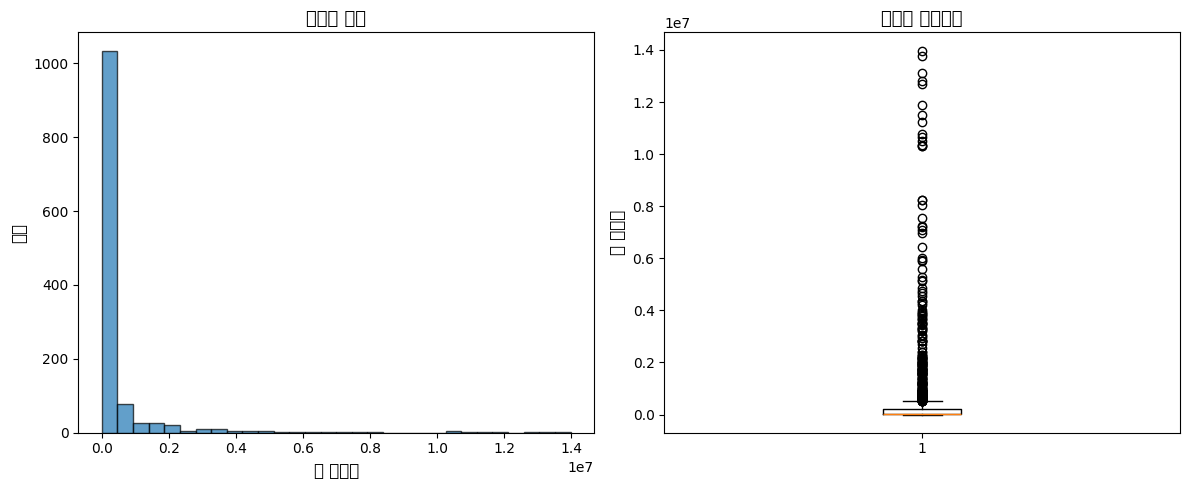


이상치 개수: 211 / 1252 (16.9%)
하한: -294,252, 상한: 510,424


In [35]:
# Target 변수 (관객수) 분포 확인
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['audiAcc'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('총 관객수', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.title('관객수 분포', fontsize=13, fontweight='bold')

plt.subplot(1, 2, 2)
plt.boxplot(df['audiAcc'])
plt.ylabel('총 관객수', fontsize=12)
plt.title('관객수 박스플롯', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# 이상치 통계
Q1 = df['audiAcc'].quantile(0.25)
Q3 = df['audiAcc'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['audiAcc'] < lower_bound) | (df['audiAcc'] > upper_bound)]
print(f"\n이상치 개수: {len(outliers)} / {len(df)} ({len(outliers)/len(df)*100:.1f}%)")
print(f"하한: {lower_bound:,.0f}, 상한: {upper_bound:,.0f}")

In [36]:
# 이상치 제거 (선택적)
# 주의: 영화 흥행은 본질적으로 큰 편차가 있으므로 신중하게 결정

# 옵션 1: 이상치 제거하지 않음 (권장)
df_clean = df.copy()
print("이상치를 유지합니다. (영화 흥행의 본질적 특성)")

# 옵션 2: 극단값만 제거 (필요시 주석 해제)
# df_clean = remove_outliers(df, columns=['audiAcc'], method='iqr', threshold=3.0)
# print(f"이상치 제거 후 데이터: {len(df_clean)} 행")

print(f"최종 데이터 크기: {df_clean.shape}")

이상치를 유지합니다. (영화 흥행의 본질적 특성)
최종 데이터 크기: (1252, 60)


## 5. Feature 선택 및 준비

In [37]:
# 모델링에 사용할 Feature 선택
# Target 변수
target = 'audiAcc'

# 제외할 컬럼 (ID, 이름, 날짜 등)
exclude_cols = [
    'movieCd', 'movieNm', 'movieNmEn', 'openDt',
    'directors', 'actors', 'genres', 'distributors', 'nations',
    'season', 'watchGradeNm', 'typeNm', 'prdtYear'
]

# Feature 컬럼
feature_cols = [col for col in df_clean.columns 
                if col not in exclude_cols + [target]]

print(f"총 Feature 개수: {len(feature_cols)}")
print(f"\nFeature 목록:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

총 Feature 개수: 46

Feature 목록:
 1. search_4w_before
 2. search_2w_before
 3. search_1w_before
 4. search_opening
 5. search_1w_after
 6. max_search
 7. avg_search
 8. search_volatility
 9. search_growth_rate
10. director_power
11. actor_power
12. ticket_power
13. genre_애니메이션
14. genre_어드벤처
15. genre_사극
16. genre_SF
17. genre_멜로/로맨스
18. genre_다큐멘터리
19. genre_뮤지컬
20. genre_판타지
21. genre_공연
22. genre_전쟁
23. genre_공포(호러)
24. genre_서부극(웨스턴)
25. genre_드라마
26. genre_액션
27. genre_범죄
28. genre_기타
29. genre_스릴러
30. genre_성인물(에로)
31. genre_코미디
32. genre_미스터리
33. genre_가족
34. genre_Unknown
35. release_month
36. release_quarter
37. release_year
38. release_dayofweek
39. is_weekend
40. season_fall
41. season_spring
42. season_summer_peak
43. season_winter_peak
44. distributor_freq
45. distributor_target
46. watchGrade_encoded


In [38]:
# X, y 분리
X = df_clean[feature_cols].copy()
y = df_clean[target].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nX 데이터 타입:")
print(X.dtypes.value_counts())

X shape: (1252, 46)
y shape: (1252,)

X 데이터 타입:
int64      24
float64    18
bool        4
Name: count, dtype: int64


## 6. 데이터 분할 (Train/Val/Test)

In [39]:
# Train : Val : Test = 70 : 15 : 15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("=== 데이터 분할 결과 ===")
print(f"Train set: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total:     {len(X)}")

=== 데이터 분할 결과 ===
Train set: 876 (70.0%)
Val set:   188 (15.0%)
Test set:  188 (15.0%)
Total:     1252


## 7. Feature Scaling

In [40]:
# 수치형 Feature만 스케일링
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"스케일링할 Feature 수: {len(numeric_features)}")

# Train 데이터로 Scaler 학습
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("Feature Scaling 완료!")

스케일링할 Feature 수: 42
Feature Scaling 완료!


## 8. 데이터 저장

In [41]:
# Processed 데이터 저장
save_data(df_clean, 'data/processed/movie_features.csv')

# Train/Val/Test 데이터 저장
X_train_scaled.to_csv('data/final/X_train.csv', index=False)
X_val_scaled.to_csv('data/final/X_val.csv', index=False)
X_test_scaled.to_csv('data/final/X_test.csv', index=False)

y_train.to_csv('data/final/y_train.csv', index=False, header=['audiAcc'])
y_val.to_csv('data/final/y_val.csv', index=False, header=['audiAcc'])
y_test.to_csv('data/final/y_test.csv', index=False, header=['audiAcc'])

# Scaler 저장
import joblib
joblib.dump(scaler, 'models/scaler.pkl')

# Feature 목록 저장
with open('data/processed/feature_description.txt', 'w', encoding='utf-8') as f:
    f.write("=== Feature 목록 ===\n\n")
    for i, col in enumerate(feature_cols, 1):
        f.write(f"{i:2d}. {col}\n")

print("\n모든 데이터 저장 완료!")
print("저장된 파일:")
print("  - data/processed/movie_features.csv")
print("  - data/final/X_train.csv, X_val.csv, X_test.csv")
print("  - data/final/y_train.csv, y_val.csv, y_test.csv")
print("  - models/scaler.pkl")
print("  - data/processed/feature_description.txt")

Data saved to data/processed/movie_features.csv

모든 데이터 저장 완료!
저장된 파일:
  - data/processed/movie_features.csv
  - data/final/X_train.csv, X_val.csv, X_test.csv
  - data/final/y_train.csv, y_val.csv, y_test.csv
  - models/scaler.pkl
  - data/processed/feature_description.txt


## 9. Feature Engineering 요약

In [42]:
print("\n" + "="*60)
print("Feature Engineering 요약")
print("="*60)

print("\n📊 생성된 Feature 그룹")
print(f"  1. 검색 트렌드 변수: {len([c for c in feature_cols if 'search' in c])}개")
print(f"  2. Ticket Power: {len([c for c in feature_cols if 'power' in c])}개")
print(f"  3. 장르: {len([c for c in feature_cols if c.startswith('genre_')])}개")
print(f"  4. 시간 기반: {len([c for c in feature_cols if 'release' in c or c.startswith('season_')])}개")
print(f"  5. 기타: {len(feature_cols) - sum([len([c for c in feature_cols if x in c]) for x in ['search', 'power']]) - len([c for c in feature_cols if c.startswith('genre_') or 'release' in c or c.startswith('season_')])}개")

print(f"\n📈 데이터셋 크기")
print(f"  - Train: {len(X_train)}")
print(f"  - Validation: {len(X_val)}")
print(f"  - Test: {len(X_test)}")
print(f"  - Total Features: {len(feature_cols)}")

print("\n" + "="*60)
print("✅ 전처리 및 Feature Engineering 완료!")
print("다음 단계: 04_baseline_model.ipynb")
print("="*60)


Feature Engineering 요약

📊 생성된 Feature 그룹
  1. 검색 트렌드 변수: 9개
  2. Ticket Power: 3개
  3. 장르: 22개
  4. 시간 기반: 8개
  5. 기타: 4개

📈 데이터셋 크기
  - Train: 876
  - Validation: 188
  - Test: 188
  - Total Features: 46

✅ 전처리 및 Feature Engineering 완료!
다음 단계: 04_baseline_model.ipynb
